In [12]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline 

In [13]:
num_epochs = 10
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

In [14]:
def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

In [15]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [16]:
# Unpack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, 1)
labels_series = tf.unstack(batchY_placeholder, axis=1)
print(len(inputs_series))
print(inputs_series[0].shape)

# Forward passes
cell = tf.contrib.rnn.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

15
(5, 1)


ValueError: Variable rnn/basic_rnn_cell/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/Users/zhaocongyuan/anaconda3/lib/python3.5/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 747, in _linear
    "weights", [total_arg_size, output_size], dtype=dtype)
  File "/Users/zhaocongyuan/anaconda3/lib/python3.5/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py", line 64, in __call__
    _linear([inputs, state], self._num_units, True, scope=scope))
  File "/Users/zhaocongyuan/anaconda3/lib/python3.5/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn.py", line 184, in <lambda>
    call_cell = lambda: cell(input_, state)


In [17]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

ValueError: Variable rnn/basic_rnn_cell/weights/Adagrad/ already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "<ipython-input-6-49d15f5bde77>", line 7, in <module>
    train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)
  File "/Users/zhaocongyuan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/Users/zhaocongyuan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):


In [18]:
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 0.704498
Step 100 Loss 0.0164675
Step 200 Loss 0.00639236
Step 300 Loss 0.00275861
Step 400 Loss 0.00213916
Step 500 Loss 0.00161558
Step 600 Loss 0.00159877
New data, epoch 1
Step 0 Loss 0.130619
Step 100 Loss 0.00173101
Step 200 Loss 0.00129559
Step 300 Loss 0.000977402
Step 400 Loss 0.000867362
Step 500 Loss 0.000877774
Step 600 Loss 0.000751316
New data, epoch 2
Step 0 Loss 0.343625
Step 100 Loss 0.000697004
Step 200 Loss 0.000667205
Step 300 Loss 0.000585871
Step 400 Loss 0.000564076
Step 500 Loss 0.000476239
Step 600 Loss 0.00044136
New data, epoch 3
Step 0 Loss 0.138118
Step 100 Loss 0.000469597
Step 200 Loss 0.000457927
Step 300 Loss 0.000383887
Step 400 Loss 0.000384963
Step 500 Loss 0.000355876
Step 600 Loss 0.000334645
New data, epoch 4
Step 0 Loss 0.204329
Step 100 Loss 0.000374702
Step 200 Loss 0.000338772
Step 300 Loss 0.000330902
Step 400 Loss 0.000300096
Step 500 Loss 0.000336676
Step 600 Loss 0.000275236
New data, epoch 5
Step 0 Loss 0.289

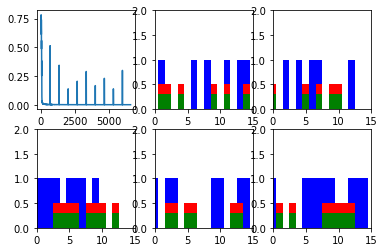

In [11]:
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))


        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()